##    <center> DSCI 100 Group Project Report
    
**Group 168**

**Anjali Dajee**

**Ross Tomita**

**Yuwen Luo**<center>
    
    
______________

# <center>Investigating pulsar star data to find an accurate predictive model using the KNN algorithm: exploratory study <center>

# 1. Introduction

Pulsars are neutron stars that form when a star collapses within itself and eventually explodes, creating a supernova. As the pulsars rotate, they produce a broadband radio emission that can be detected from earth using a large dish antenna and a radio. Since each pulsar’s emission is slightly different during each rotation, a singular signal detection is made by averaging several rotation emissions of the star (Lyon et al.)  However, most detections are actually interfering man-made radio signals, and not actual pulsars. To determine whether a detection is truly a pulsar, other variables must be considered. The discovery of pulsars has allowed scientists to observe neutron stars for the first time, as well as test some of the conditions of Einstein’s theory of relativity.

In the current study, we will explore the HTRU2 dataset which describes samples of known pulsar and non-pulsar stars. This dataset is described by 9 different attributes in which 8 quantitative variables come from two different curves:

- The first is an `average integrated pulse profile` of a single pulsar star. To account for minor discrepancies in each pulse, several emissions are averaged and put together to create a single pulse profile for a star. 

- The second curve accounts for delay when pulses arrive at differing time across different radio frequencies. This delay, or dispersion, can be fit and compensated for in astronomers’ calculations, however there is always a certain measure of uncertainty. This is accounted for in the “dispersion-measure-signal-to-noise-ratio” `(DM-SNR) curve`. 

From these two curves, 8 numerical features can be calculated and standardized. From the integrated pulse profile, we get;  `Mean, Excess Kurtosis, Skewness, and Standard Deviation`. From the DM-SNR curve, the `same four variables` can be acquired. 

The ninth variable, `Class`, is a categorical variable with 2 different levels, which is what we will be trying to predict (Scaife). 
<blockquote>
    0 represents negative examples (false detections for pulsar starts);
</blockquote>
<blockquote>
    1 represents positive examples (true detections for pulsar starts).
</blockquote>

We will use these in our analysis to determine **whether any of these can be used to accurately classify whether a detection is a pulsar star or not**. We have also taken into consideration that the number of true pulsar stars is a minority positive class, while the number of false detections is a majority negative class. This information will be useful when sampling  the training set from the original dataset. 


_____________________________________

# 2. Methods & Results

## 2.1 Import data, tidy data

In [1]:
library(tidyverse)
library(ggplot2)
library(dplyr) 
library(tidymodels)
library(GGally)
library(ggfortify)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We first loaded the Pulsar dataset from its URL, and set the column names. 

In [2]:
# import data
#temp  <- tempfile()
#download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip",temp)
pulsar <- read.csv("https://raw.githubusercontent.com/RowanYuwenLUO/dsci100_2022w1_group168/main/HTRU_2.csv",
                   header = FALSE, 
                   col.names = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness",
                                 "Class"))
# view the pulsar dataset
head(pulsar)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
2,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
3,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
4,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
5,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
6,93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


<center>Table 1: view for original pulsar dataset<center>

In [3]:
# dimension of the data set
dim(pulsar) 

[1] 17898     9

In [4]:
# check the missing data
sum(is.na(pulsar))

[1] 0

In [5]:
# show number of observations in each class
count_data <- pulsar %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar))
count_data 

Class,n,freq
<int>,<int>,<dbl>
0,16259,0.90842552
1,1639,0.09157448


Table 2: number of observations (original dataset) in each class

#### Summary for the original Pulsar Dataset:

- Inspecting the dataset, there is no missing data and the original dataset includes 17898 observations (rows), and 9 variables (columns): 8 continuous and 1 categorical variables. 

- We want to predict the value of the Class variable, which represents whether a given observation is a Pulsar (with `Class 1 being true` and `Class 0 being false`). We will do this by using the remaining 8 variables (which will hereon be referred to as our predictors).

- We find that majority of the data (around 90%) are in class 0, and also will check the imbalancing problem when we analyze the training set.

## 2.2 Split data into training and testing sets 

We then split our data into training (75%) and testing (25%) sets. 

In [6]:
set.seed(123)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

In [7]:
### 2.3 Pre-processing the training set

In [8]:
# number of observations in each class
count_train <- pulsar_train %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar_train))
count_train

Class,n,freq
<int>,<int>,<dbl>
0,12170,0.90665276
1,1253,0.09334724


Table 3: number of observations (training set) in each class

We then calculate the proportion of each class in the training set. The training set shows the almost same proportion as the original dataset.
We found that there was a disproportionately lower amount of pulsar star data (Class 1) than non-pulsar star data (Class 0), as can be seen in the distribution plot below. This presented us with a class imbalance problem.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



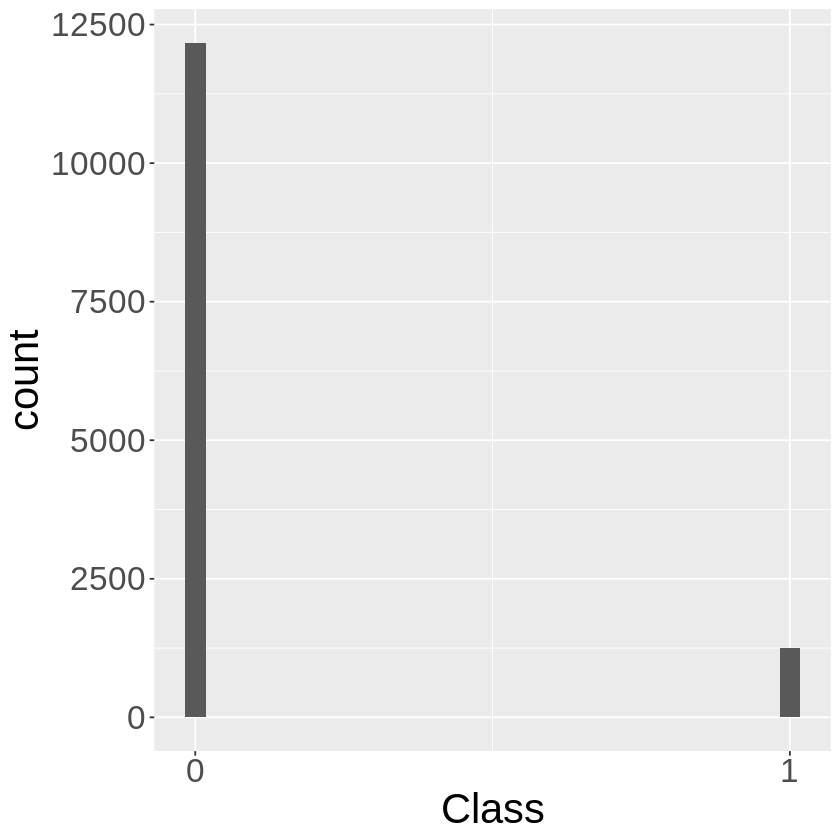

In [9]:
# display the distribution in training set using histogram
ggplot() + 
  geom_histogram(pulsar_train, mapping = aes(Class)) + 
  scale_x_continuous(breaks = 0:1) + 
  theme(text = element_text(size=25)) 

Figure 1: distribution of each class in training set

In [10]:
### 2.3.1 Resolve imbalance problem by sampling down the 0 (negative) class

In [11]:
# dimension of the training data set 
dim(pulsar_train) 

[1] 13423     9

Since the number of observations in training set is sufficiently large, we reduced the size of the abundant class to resolve this imbalancing problem.

In [12]:
# sample down the class 0 in training set 
set.seed(123)
train_c1 <- filter(pulsar_train, Class == 1)
train_c0 <- filter(pulsar_train, Class == 0)

sample_down_train <- pulsar_train %>% 
  filter(Class ==0) %>%
  sample_n(nrow(train_c1)) %>%
  rbind(train_c1)

# dimension for the training data after sampling down
dim(sample_down_train)

[1] 2506    9

In [13]:
# number of observations in each class after sampling down
count_train2 <- sample_down_train %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(sample_down_train))
count_train2

Class,n,freq
<int>,<int>,<dbl>
0,1253,0.5
1,1253,0.5


Table 4: number of observations (training set after sampling down) in each class

We sampled down the pulsar class variable so that the number of pulsar star data (Class 1) was equal to the number of non-pulsar star data (Class 0) in the training set. After this, the proportion for both classes was the same. And we got a training set with 2506 observations, which was still a large training set even after under-sampling.

In [14]:
### 2.3.2 Scale the training set after sampling down it

In [15]:
# calculate the means of the predictor variables
predictors_mean <- sample_down_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(predictors_mean) <- "mean"
predictors_mean

,mean
,<dbl>
integr.mean,86.256958
integr.std,42.861345
integr.kurtosis,1.700721
integr.skewness,8.177292
DMSNR.mean,29.887667
DMSNR.std,40.028187
DMSNR.kurtosis,5.824315
DMSNR.skewness,67.323829


Table 5: means for each predictor

Next, looking at the mean values for each of our predictor variables, we saw that there were large differences between the means of the predictors. Since we will use KNN algorithm with depends on euclidean distance between observations, this required us to scale the data so that predictors would all be weighted equally.  

In [16]:
all_predictors_name <- colnames(sample_down_train[, 1:8])

scaled_train <- sample_down_train %>% 
  mutate_at(all_predictors_name, ~(scale(.) %>% as.vector))

scaled_predictors_mean <- scaled_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(scaled_predictors_mean) <- "mean"
scaled_predictors_mean

,mean
,<dbl>
integr.mean,1.686572e-16
integr.std,3.168992e-16
integr.kurtosis,1.484137e-17
integr.skewness,-3.649426e-17
DMSNR.mean,-1.664808e-17
DMSNR.std,-1.331459e-16
DMSNR.kurtosis,5.974620e-17
DMSNR.skewness,-7.091184e-18


Table 6: means for each predictor after scaling

After scaling the variables, all of our predictors now had a mean of zero, which allowed us to perform further analyses on them to figure out which ones we should choose.  

### 2.3.3 Visualize the training set

In [17]:
head(scaled_train)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.9530132,1.8106637,-0.8168831,-0.7010886,-0.6561685,-1.0755796,0.89087155,0.7126506,0
2,1.0886967,3.6593985,-0.8675785,-0.7536754,1.5101584,1.5944108,-1.15877415,-0.6803251,0
3,1.3450323,0.5883488,-1.0096455,-0.6209852,-0.6637171,-1.0960985,1.17488947,1.0446210,0
4,0.7439764,1.0821099,-0.6363887,-0.6296116,-0.3042426,0.5808810,-0.59015834,-0.5998106,0
5,0.8339644,-0.0828916,-0.6085113,-0.5989493,-0.5693893,-0.3795561,-0.00139643,-0.3265444,0
6,-0.1064005,-0.6559463,-0.4430658,-0.4385813,-0.6034269,-0.5059058,0.22646530,-0.1780283,0


Table 7: view for processed training set

We created the histogram and boxplot, both are used to explore the relationship between continuous variables and a categorical variable. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



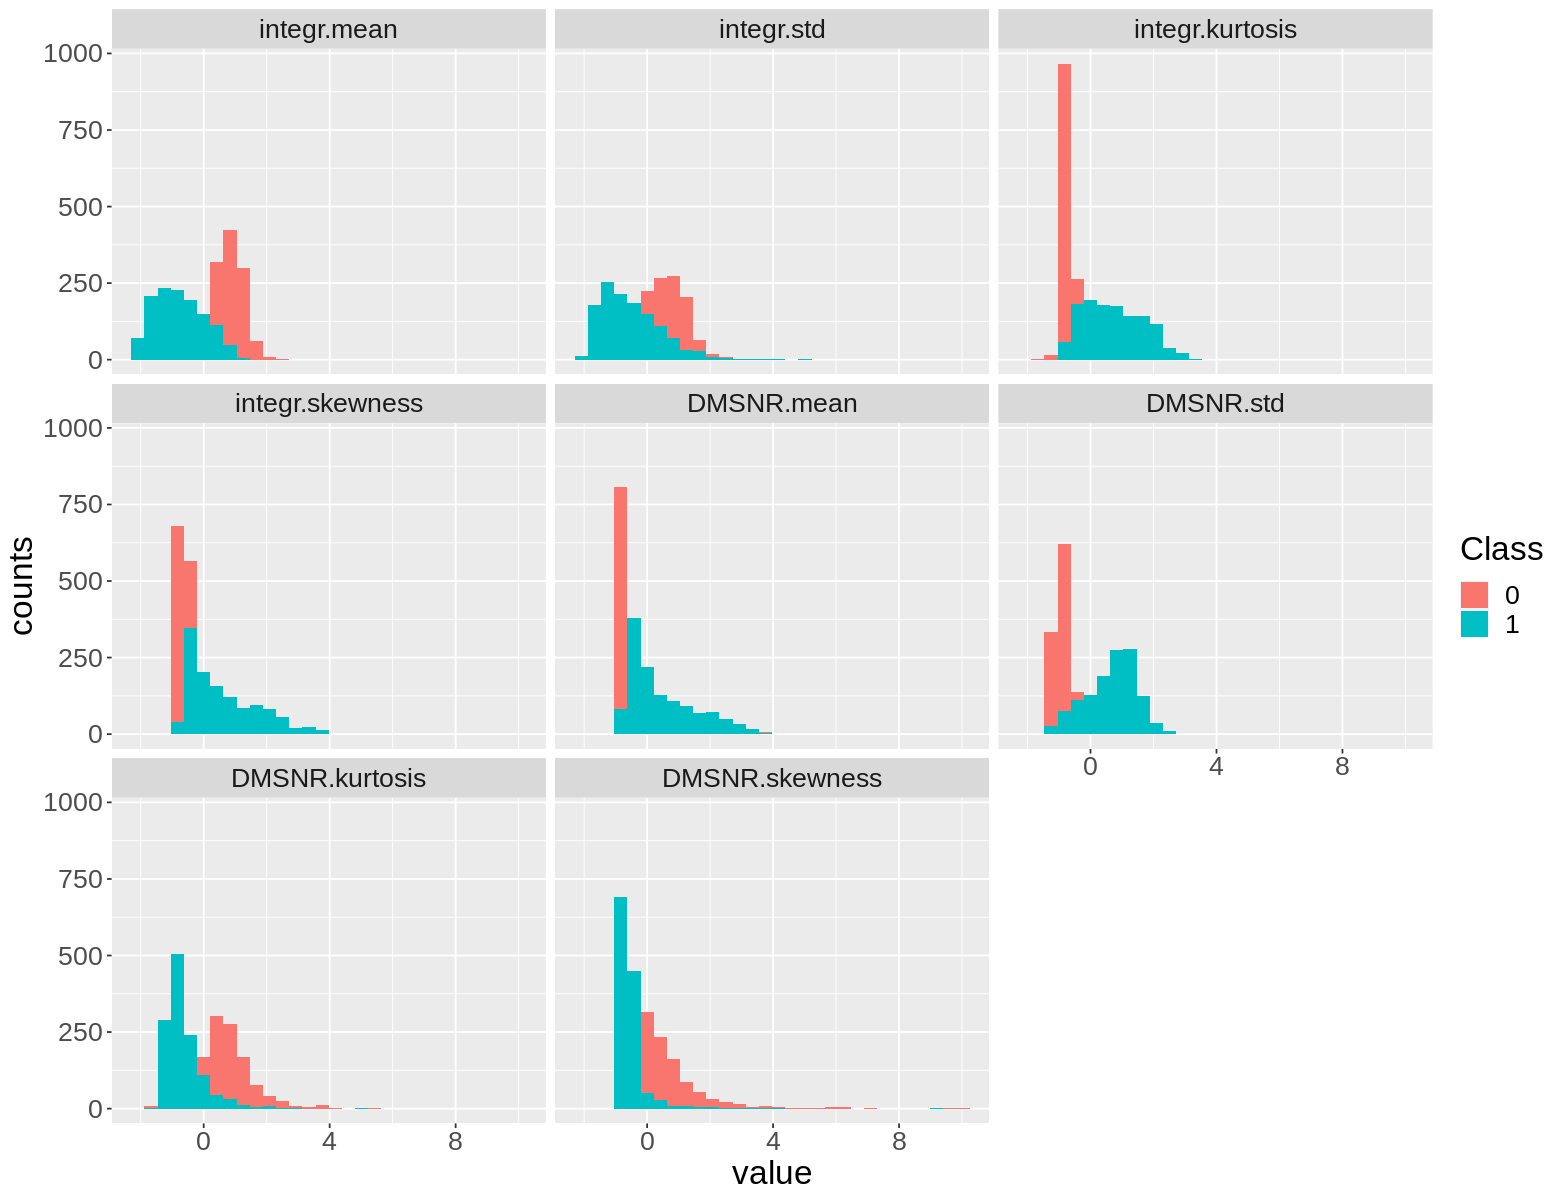

In [18]:
pivot_train <- scaled_train %>%
  pivot_longer(cols = integr.mean:DMSNR.skewness,
               names_to = "predictor", 
               values_to = "value")
# histogram for all 8 variables
options(repr.plot.width = 13, repr.plot.height = 10) 

pivot_train %>% 
  ggplot(aes(x = value, fill = as.factor(Class))) + 
  geom_histogram(position = "identity") + 
  facet_wrap(~ factor(predictor, 
                      levels = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness"))) +
  xlab("value") + 
  ylab("counts") + 
  labs(fill = "Class") +
  theme(text = element_text(size=20)) 

Figure 2: Histogram of class on each predictor in training set

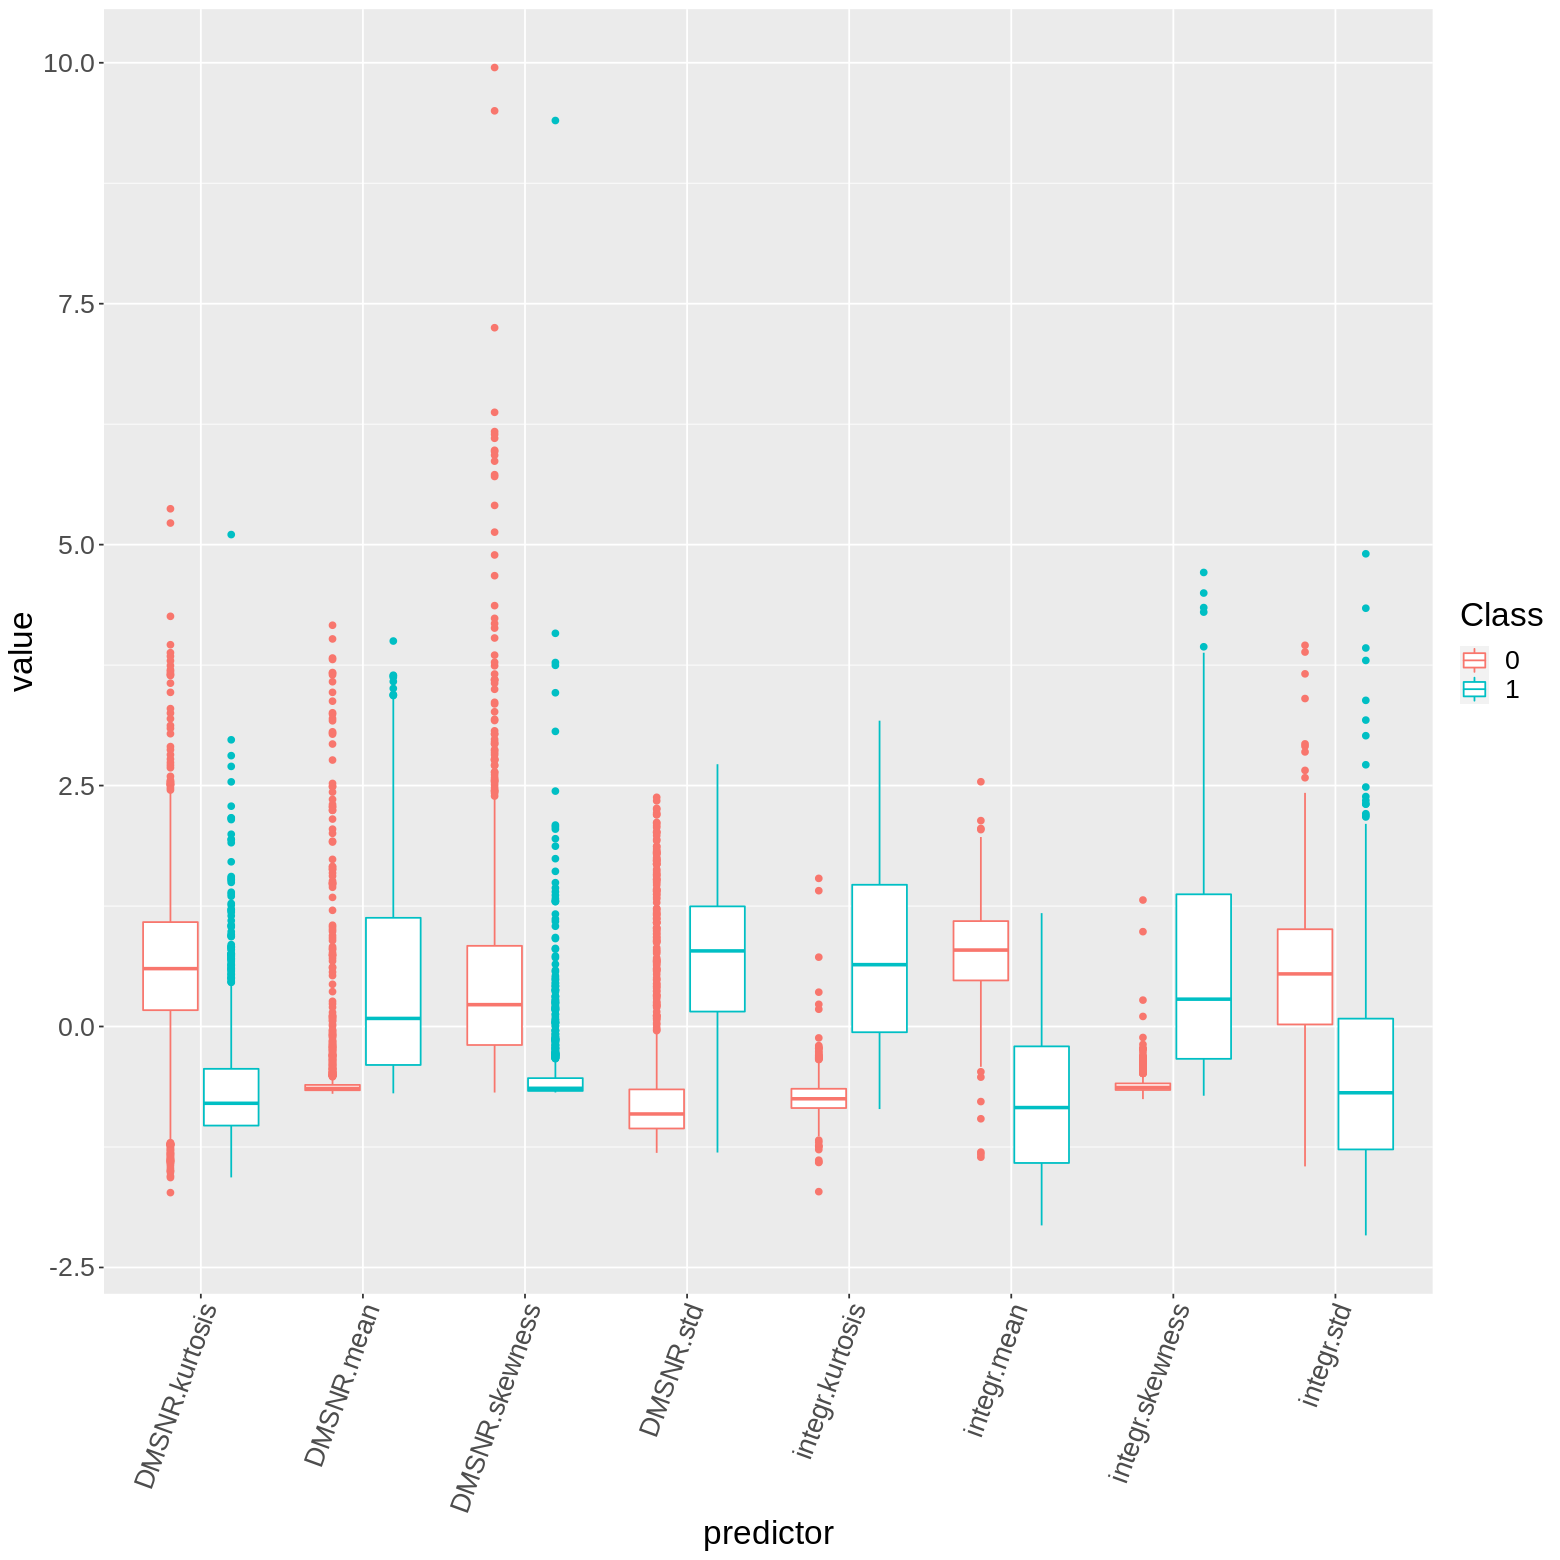

In [19]:
# boxplot
options(repr.plot.width = 13, repr.plot.height = 13) 

ggplot(pivot_train, aes(x=predictor, y=value, color = as.factor(Class))) + 
  geom_boxplot() + 
  labs(color = "Class") +
  theme(axis.text.x = element_text(angle = 70, hjust = 1),
        text = element_text(size=20)) 

Figure 3: Boxplot of each class

We compared the distribution of pulsar and non pulsar stars (Class 1 and Class 0) on each of the 8 predictors. From the histogram and boxplot we found that:
> - `integr.mean`, `integr.std`, `DMSNR.kurtosis`, `DMSNR.skewness` predictors has larger mean in Class 0;
> - `integr.kurtosis`, `integr.skewness`, `DMSNR.std`, `DMSNR.mean` predictors has larger mean in Class 1;
>- data from `DMSNR.skewness` in Class 0 has the most spread distribution;
>- all predictors have a lot of outliers shown from the boxplot;
>- almost all predictors in both Classes show skewed to right distribution, except the `DMSNR.std` variable.

In doing this, the plots helps examine the differences between the the two category classes on each predictor. And we wanted to see if the distributions of both classes on any variables did have significant overlap or clear separation, which could be helpful for choosing predictors. 

## 2.4 Data Analysis: K-NN Classification 

## 2.4.1 Classification: using predictors chosen from Forward selection

In [20]:
set.seed(123)

pulsar_all_training <- scaled_train %>%
  mutate(Class = as.factor(Class))

# tuning the parameter - find best k when all predictors included
pulsar_recipe <- recipe(Class ~ . , data = pulsar_all_training)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# create a 10-fold cross-validation object
vfold <- vfold_cv(pulsar_all_training, v = 10, strata = Class)

# try K with different values:  1 to 100 (stepping by 5) 
ks <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# accuracy results
knn_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracies[which.max(accuracies$mean), ]
k <- accuracies[which.max(accuracies$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9297714,10,0.003772848,Preprocessor1_Model03


Forward selection is a process wherein we start with zero predictors, and then iteratively add the most contributive predictors. We stop adding more predictors when adding any more stops being statistically significant. We first performed a forward selection on our training data with best k (k = 11) we found in the above process when all predictors included in the classification model. With forward selection we want to determine what combination of predictors would yield high accuracy. The results were summarized in the following output table. 

In [21]:
# forward selection
names <- colnames(pulsar_all_training 
                  %>% select(-Class))
example_formula <- paste("Class", "~", paste(names, collapse="+"))
example_formula 

[1] "Class ~ integr.mean+integr.std+integr.kurtosis+integr.skewness+DMSNR.mean+DMSNR.std+DMSNR.kurtosis+DMSNR.skewness"

In [22]:
# forward selection. cont.
set.seed(123)

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 10-fold cross-validation
vfold <- vfold_cv(pulsar_all_training, v = 10, strata = Class)
# store the total number of predictors
n_total <- length(names)
# stores selected predictors
selected <- c()

In [23]:
# forward selection. cont.
set.seed(123)
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_all_training)

        acc <- workflow() |>
          add_recipe(pulsar_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = vfold, grid = k) |> 
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [24]:
accuracies[which.max(accuracies$accuracy),]

size,model_string,accuracy
<int>,<chr>,<dbl>
4,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness,0.9397683


In [25]:
set.seed(123)

forward_select <- scaled_train %>%
  select(c(integr.kurtosis, DMSNR.std, 
           DMSNR.mean, integr.skewness, Class)) %>%
  mutate(Class = as.factor(Class))

# tuning the parameter 
# --- find best k with this combination of predictors (chosen from forward selection)
pulsar_recipe_forward <- recipe(Class ~ . , data = forward_select)  # training data are already scaled

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# create a 10-fold cross-validation object
vfold <- vfold_cv(forward_select, v = 10, strata = Class)

# try K with different values:  1 to 100 (stepping by 5) 
ks <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# accuracy results
knn_results <- workflow() %>%
  add_recipe(pulsar_recipe_forward) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracies[which.max(accuracies$mean), ]
k <- accuracies[which.max(accuracies$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,accuracy,binary,0.9393556,10,0.003583601,Preprocessor1_Model04


In [26]:
# build the model using the predictors choose from forward selection and tunned k
set.seed(123)
pulsar_recipe_forward <- recipe(Class ~ . , data = forward_select)  # training data are already scaled
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
  set_engine("kknn") %>%
  set_mode("classification")
pulsar_fit_forward <- workflow() %>%
  add_recipe(pulsar_recipe_forward) %>%
  add_model(pulsar_spec) %>%
  fit(data = forward_select)

In [27]:
# predict the test set
set.seed(123)

preds_forward <- predict(pulsar_fit_forward, pulsar_test) %>%
  bind_cols(pulsar_test)

# prediction results
# accuracy
preds_forward %>% mutate(Class = as.factor(Class)) %>%
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy") 
# confusion matrix
preds_forward %>%
  mutate(Class = as.factor(Class)) %>%
  conf_mat(truth = Class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.09899441


          Truth
Prediction    0    1
         0   65    8
         1 4024  378

Table 8: Confusion Matrix (forward selection predictors)

By applying forward selection method, we used the combination of predictors (integr.kurtosis + DMSNR.std + DMSNR.mean + integr.skewness) which has highest accuracy on training set to fit the model. However, the prediction result shows that the accuracy on testing set is very low, even much lower than what we expected, and the confusion matrix indicates that large number of observations are misclassified in testing set. Therefore, we try to use another method to choose the predictors 

## 2.4.2 Classification: using predictors chosen from Correlation Matrix

In [28]:
corr.mat <- cor(scaled_train)
corr.mat[ , ncol(corr.mat), drop = FALSE] 

,Class
integr.mean,-0.7750963
integr.std,-0.5205059
integr.kurtosis,0.7349228
integr.skewness,0.6084140
DMSNR.mean,0.4673093
DMSNR.std,0.6662586
DMSNR.kurtosis,-0.6282438
DMSNR.skewness,-0.4900915
Class,1.0000000


Table 9: Correlation between Class and each predictor

Since the categorical variable Class `Class` has been tranformed into a `dummy variable`: has values equal to either 0 or 1. We then created a correlation matrix for our training data. We found that the predictors `integr.mean`, `integr.kurtosis` were the most correlated with Class. We also found the predictors `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` to be relatively strong correlated with Class. Given this, we used these five predictors in the next step when performing our classification. 

### use predictors chosen from correlation matrix to do the KNN-Classification

We began our classification by creating a dataframe containing our five chosen predictors in addition to our class variable, which we made into a factor data type. We created a recipe which contained these predictors as well and then performed 10-fold cross validation on our training data. 

In [29]:
pulsar_training <- scaled_train %>%
  select(c(integr.mean, integr.kurtosis, integr.skewness,
           DMSNR.std, DMSNR.kurtosis, Class)) %>%
  mutate(Class = as.factor(Class))

# cross validation - classification with 10 folds
vfold <- vfold_cv(pulsar_training, v = 10, strata = Class)

Next we created a KNN classification model and set our k value to be tuned. Using our training data, we then created a plot to show how accuracy change with K as K values increase from 1 to 100 to find the best K value. From the following resulting graph, we found that using a K = 6 would yield the most accurate predicted accuracy. 

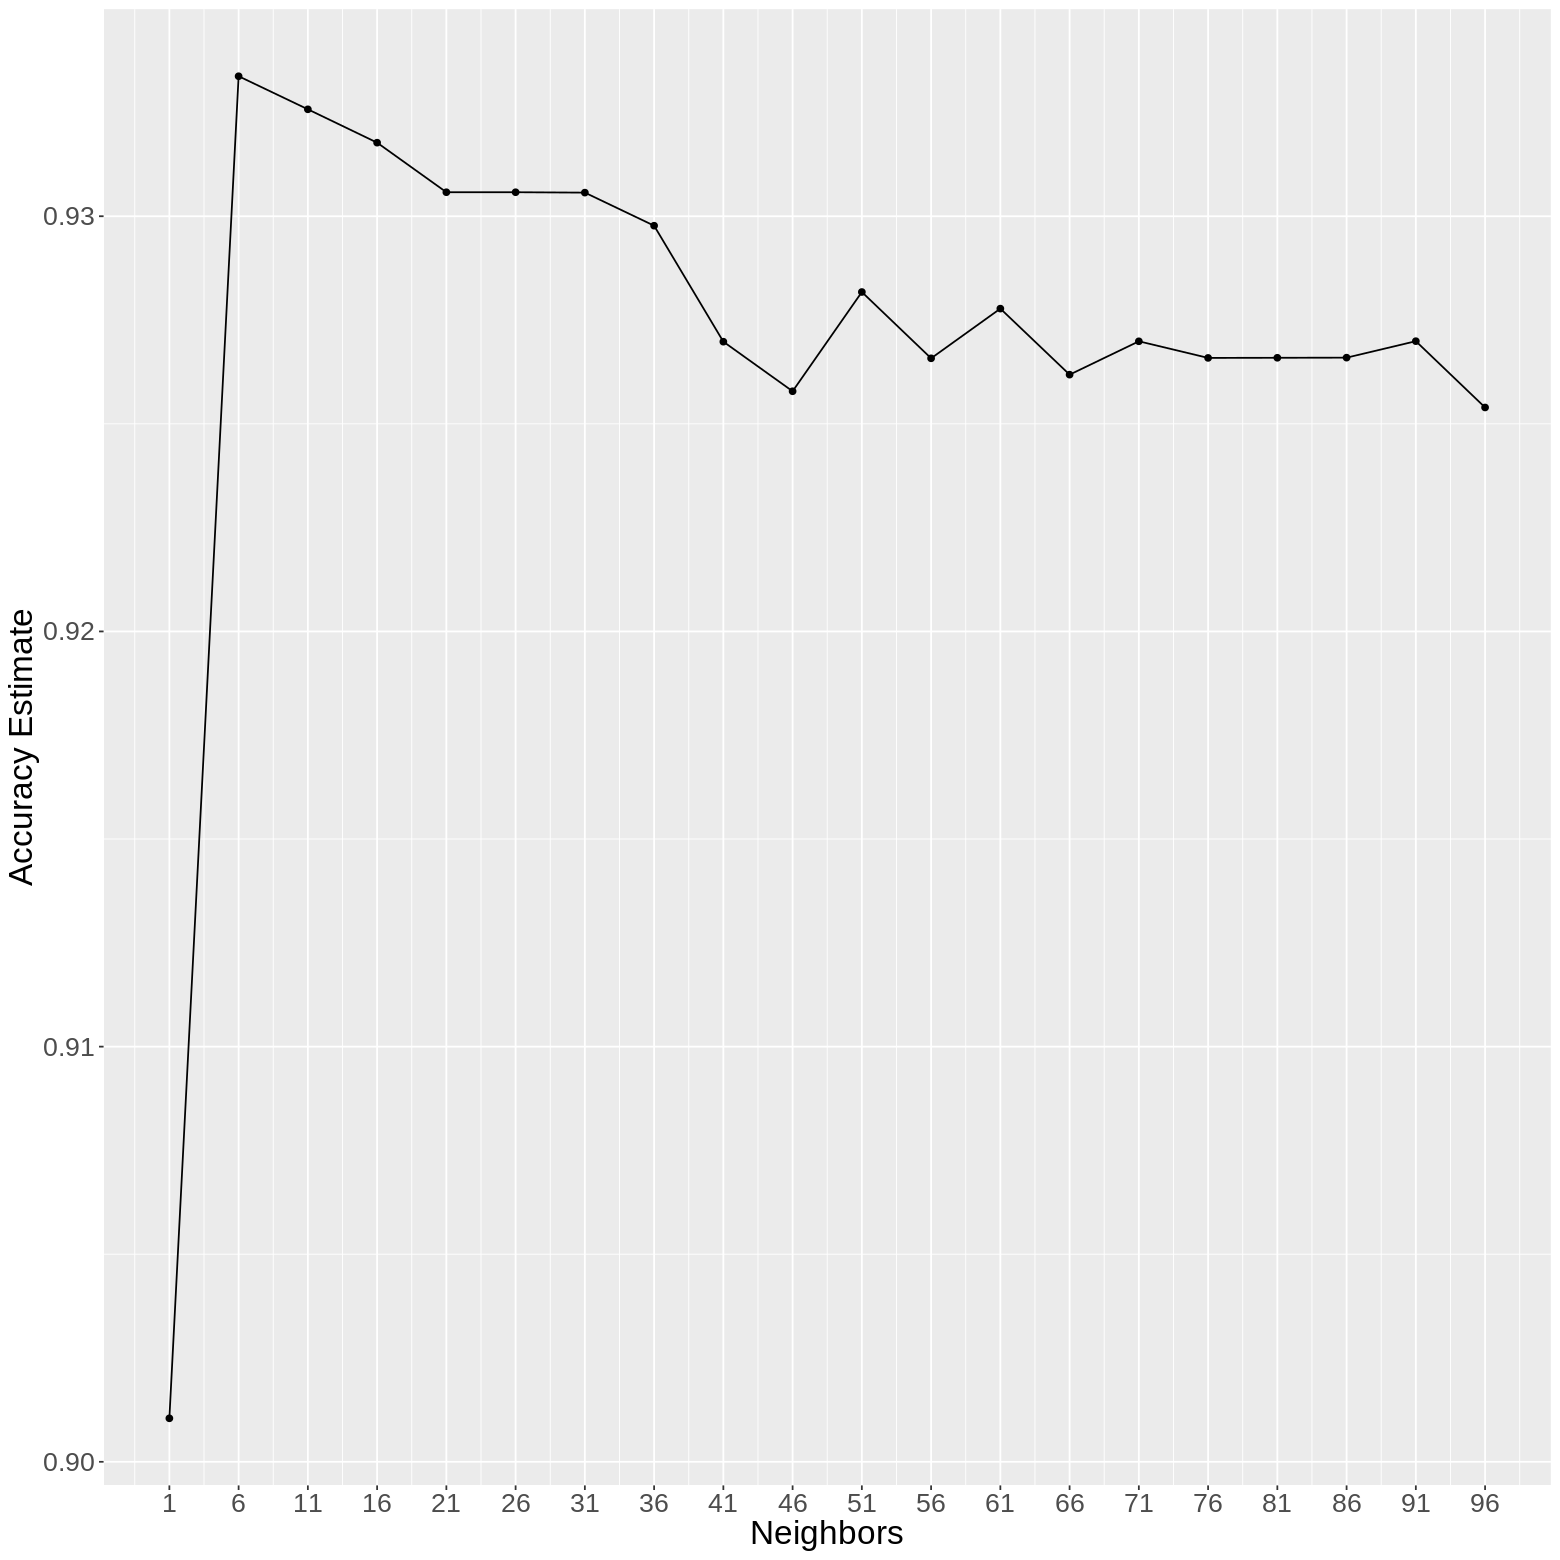

In [30]:
# tuning the parameter - choose the best k
set.seed(123)
pulsar_recipe <- recipe(Class ~ . , data = pulsar_training) # training data are already scaled

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# try K with different values:  1 to 100 (stepping by 5)
ks <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

# accuracy_vs_k 
options(repr.plot.width = 10, repr.plot.height = 10) 
accuracy_vs_k_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", main = "Accuracy VS K") + 
  theme(text = element_text(size = 20)) + 
  scale_x_continuous(breaks = ks$neighbors)
accuracy_vs_k_plot

<center>Figure 4: Accuracy vs. K plot<center>

In [31]:
# get the best k
accuracies[which.max(accuracies$mean), ]
best_k <- accuracies[which.max(accuracies$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.9333714,10,0.004394289,Preprocessor1_Model02


We then created a KNN classification model with our training data and specifications from the previous steps, using a best K equals to 6. 

In [32]:
# build the model using the best k choose from examine the accuracies
set.seed(123)
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") %>%
  set_mode("classification")
pulsar_fit <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(pulsar_spec) %>%
  fit(data = pulsar_training)

In [33]:
# predict the test set
set.seed(123)
preds <- predict(pulsar_fit, pulsar_test) %>%
  bind_cols(pulsar_test)

# accuracy
metrics <- preds %>% mutate(Class = as.factor(Class)) %>%
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy") 
metrics

# confusion matrix
confusion_mat <- preds %>%
  mutate(Class = as.factor(Class)) %>%
  conf_mat(truth = Class, estimate = .pred_class)
confusion_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9264804


          Truth
Prediction    0    1
         0 4089  329
         1    0   57

Table 10: Confusion Matrix

Finally, we tested this model using the testing data that we kept separate from the training data up until this point. We then collected accuracy metrics to determine how well our model was able to correctly classify a star as being a pulsar. We also created a confusion matrix to get a clearer picture.
<br>
The prediction results show that this model performs quite well, especially when the true Class is 0, all predicted class are true in our seed. However, it performs not so well when the true class is Class 1:
When true class is 1, about $\frac{329}{329+57} = 85\%$ were misclassified as class 0.
<br>
In all, the prediction results show that the accuracy, 0.93, is high, which means that 93% of the predicted class is the same as the actual class. 

____________________

# 3. Multicollinearity Problem and Additional Analysis

## 3.1  Multicollinearity Problem

There's multicollinearity problem between these predictors we choose since the correlations between each of them are quite high, especially between the `integr.mean`, `integr.kurtosis`, and `integr.skewness` predictors: absolute correlations are higher than 0.7, indicating strong correlation between them. In addition, predictors `DMSNR.std` and `DMSNR.mean` also have strong correlation. Also, recalling the correlation matrix, it also shows strong correlations between each variables. Therefore, it's very likely to have multicollinearity problem in our model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



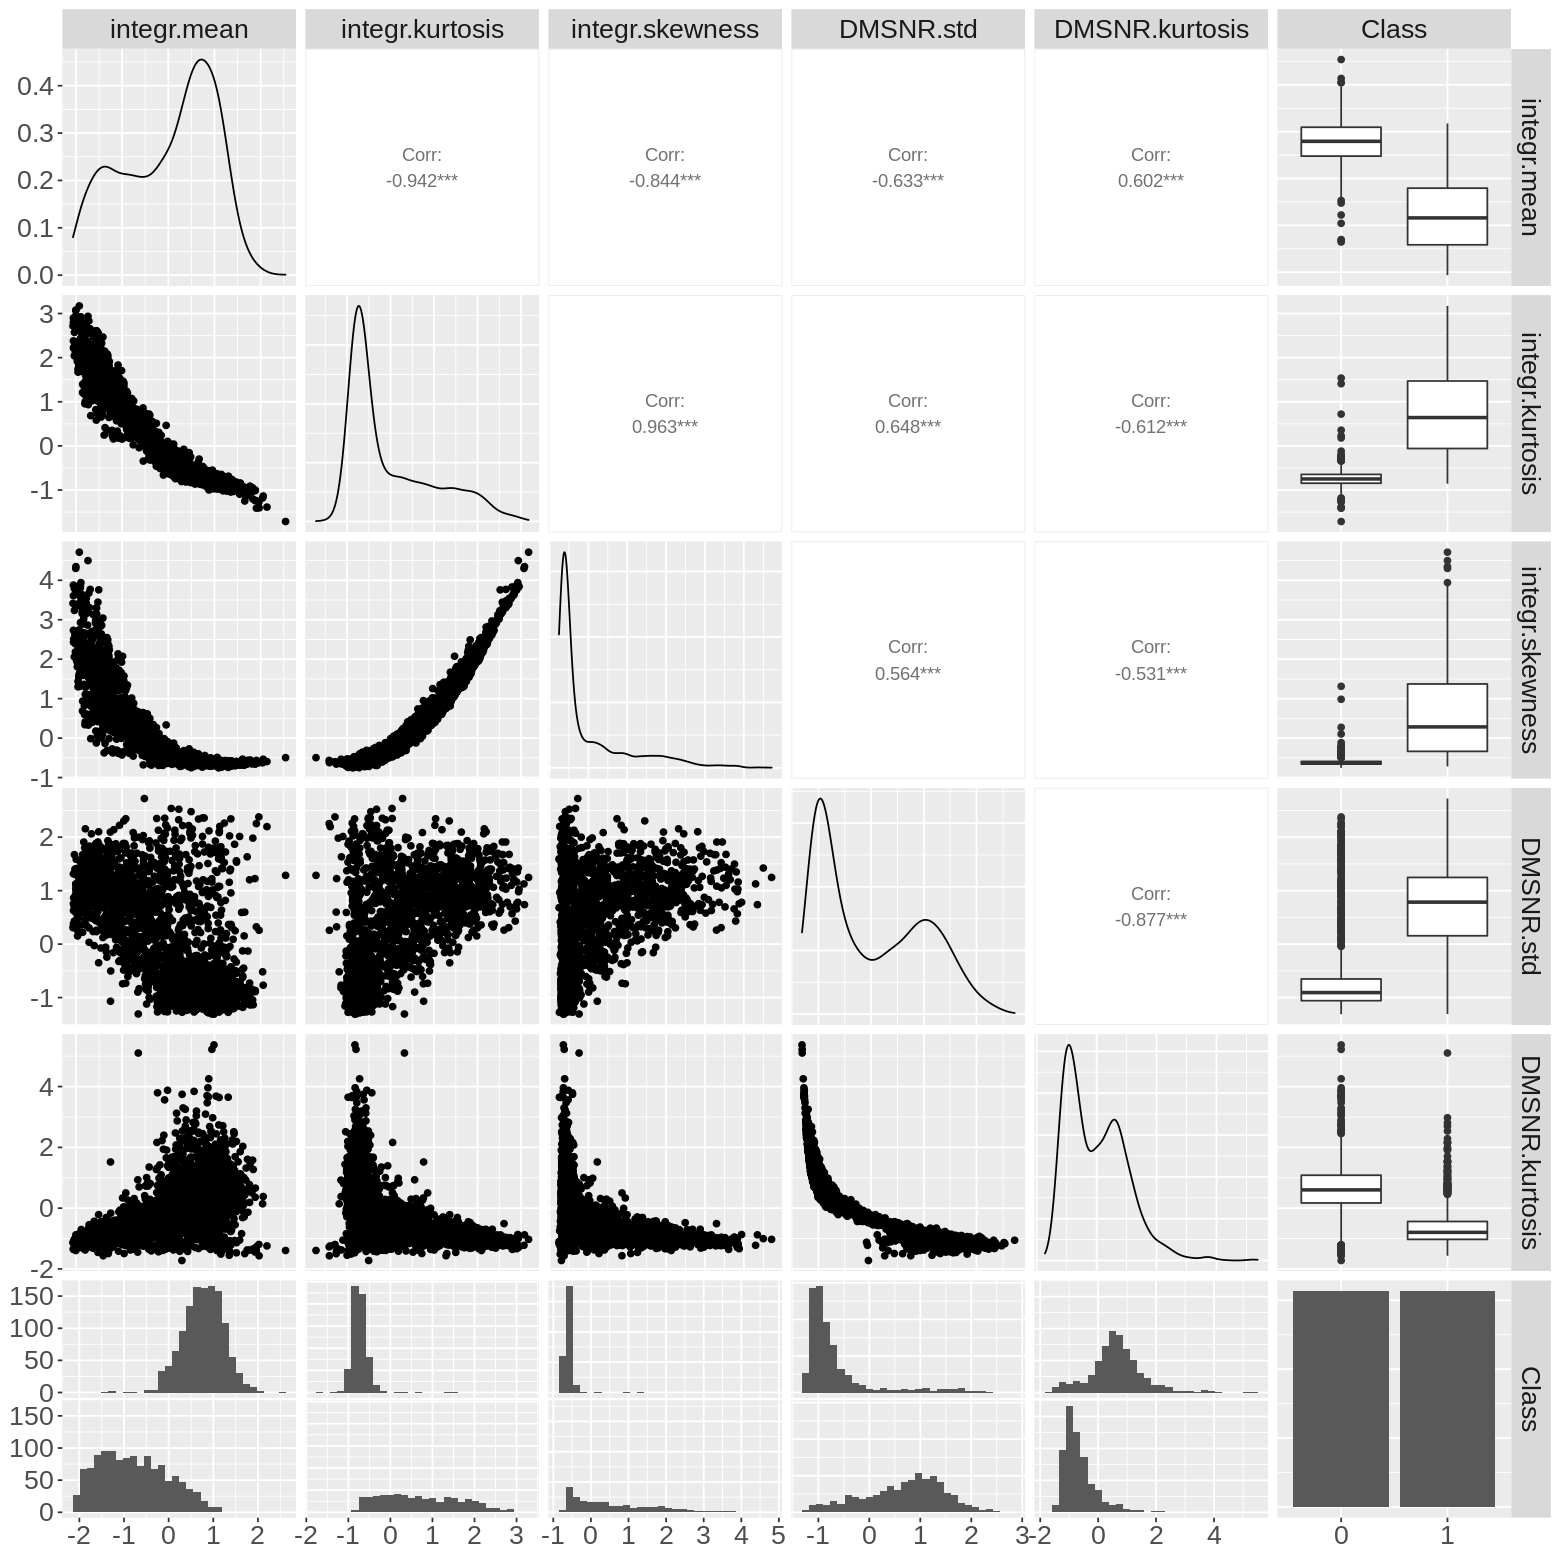

In [34]:
## ggpair plot - check the correlation between each variables in the training set
ggpairs(pulsar_training) + 
  theme(text = element_text(size=20))

<center>Figure 5: ggpair plot for the 5 chosen predictors<center>

In [35]:
## recall the correlation matrix
corr.mat

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
integr.mean,1.0000000,0.6872586,-0.9422078,-0.8437732,-0.5669821,-0.6332698,0.6017493,0.4353288,-0.7750963
integr.std,0.6872586,1.0000000,-0.7253721,-0.7359978,-0.2027974,-0.3349863,0.3179430,0.2526690,-0.5205059
integr.kurtosis,-0.9422078,-0.7253721,1.0000000,0.9632965,0.5881824,0.6483486,-0.6119384,-0.4403267,0.7349228
integr.skewness,-0.8437732,-0.7359978,0.9632965,1.0000000,0.5384755,0.5636006,-0.5311853,-0.3762123,0.6084140
DMSNR.mean,-0.5669821,-0.2027974,0.5881824,0.5384755,1.0000000,0.7846939,-0.6949288,-0.4344707,0.4673093
DMSNR.std,-0.6332698,-0.3349863,0.6483486,0.5636006,0.7846939,1.0000000,-0.8769701,-0.6560657,0.6662586
DMSNR.kurtosis,0.6017493,0.3179430,-0.6119384,-0.5311853,-0.6949288,-0.8769701,1.0000000,0.9151934,-0.6282438
DMSNR.skewness,0.4353288,0.2526690,-0.4403267,-0.3762123,-0.4344707,-0.6560657,0.9151934,1.0000000,-0.4900915
Class,-0.7750963,-0.5205059,0.7349228,0.6084140,0.4673093,0.6662586,-0.6282438,-0.4900915,1.0000000


<center>Table 11: Correlation Matrix<center>

## 3.2 Additional Analysis with PCA (Principal Component Analysis)

The original dataset has 8 predictors and most of them have strong correlations between each other, since they are some simple statistics calculated from the integrated pulse profile and DM-SNR curve file. Principal component analysis (pca) is a method to deal with the multicollinearity problem. This enables us to view the relationships inherent between subsets of variables. Also, it help us reduce the dimension of the dataset but at the same time covers as much variations in the dataset as possible. 

In [36]:
pulsar_df <- mutate(pulsar, Class = as.factor(Class))
X <- select(pulsar_df, integr.mean:DMSNR.skewness) # use all the predictors
# PCA
pulsar_pca <- prcomp(X, scale = TRUE) # scale the dataset
summary(pulsar_pca) 

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.0332 1.4644 0.8996 0.67633 0.50816 0.39985 0.14298
Proportion of Variance 0.5168 0.2681 0.1012 0.05718 0.03228 0.01998 0.00256
Cumulative Proportion  0.5168 0.7848 0.8860 0.94318 0.97546 0.99544 0.99800
                          PC8
Standard deviation     0.1266
Proportion of Variance 0.0020
Cumulative Proportion  1.0000

Table 12: PCA Summary 

### 3.2.1 visualization for PCA

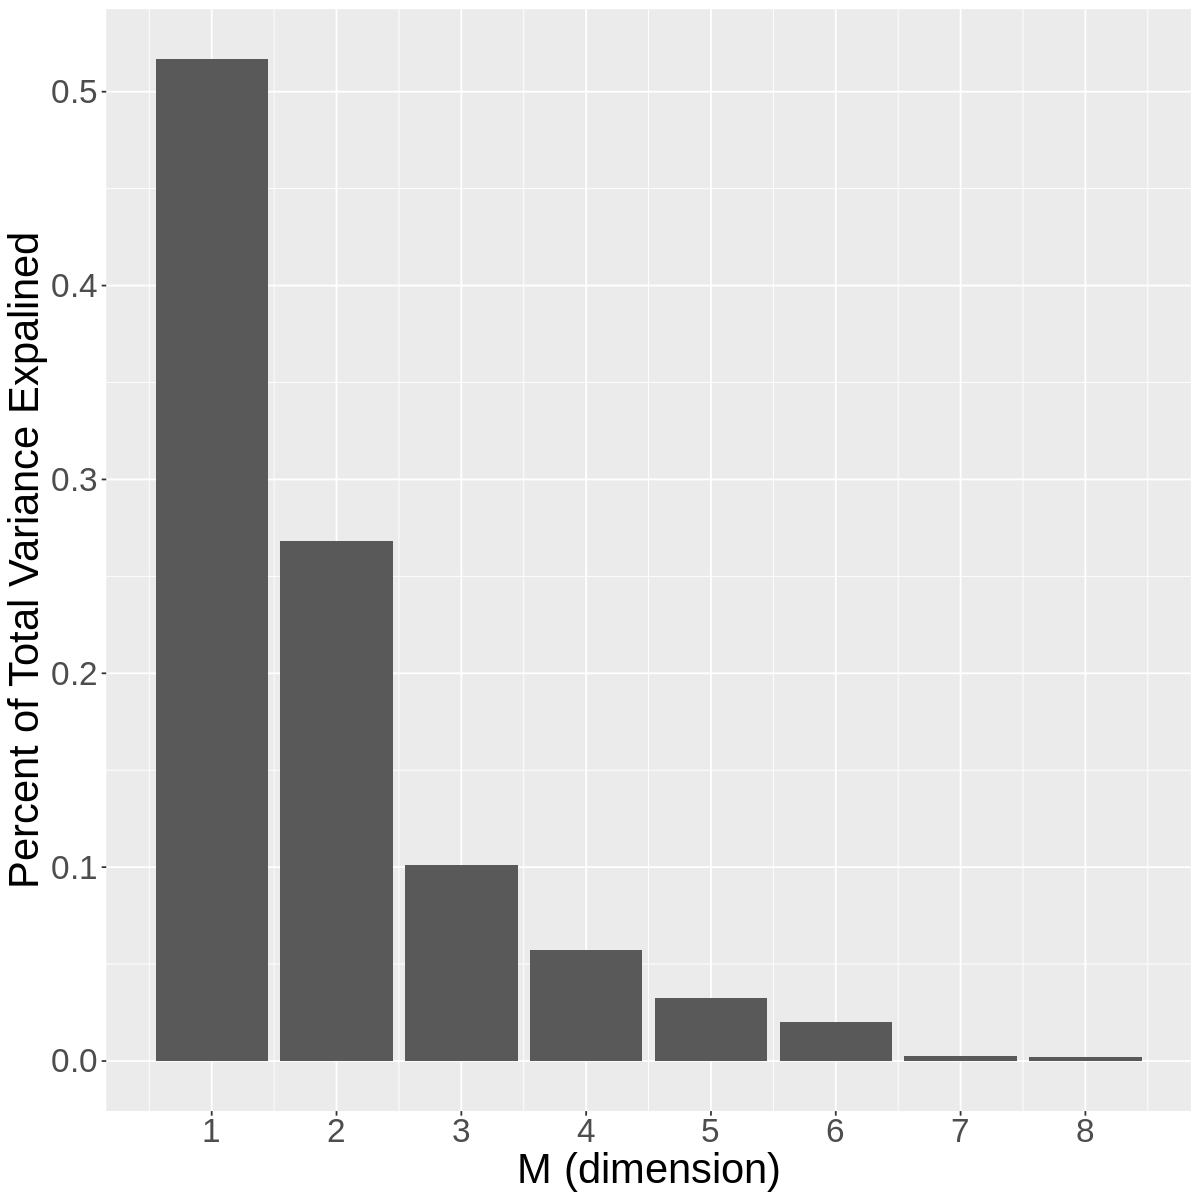

In [38]:
# screeplot
options(repr.plot.width = 10, repr.plot.height = 10) 
data.frame(dim = 1:ncol(X), 
           var_explained = pulsar_pca$sdev^2 / sum(pulsar_pca$sdev^2)) %>%
  ggplot(aes(x = dim, y = var_explained)) + 
  geom_bar(stat = "identity") + 
  labs(x = "M (dimension)", 
       y = "Percent of Total Variance Expalined", 
       main = "scree plot for PCA") + 
  scale_x_continuous(breaks = 1:ncol(X)) + 
  theme(text = element_text(size=25))

Figure 6: Screeplot for PCA

The screeplot for PCA shows that first two principal components explained about 78% of variance in the dataset, thus, using 2 dimensions seems reasonable.

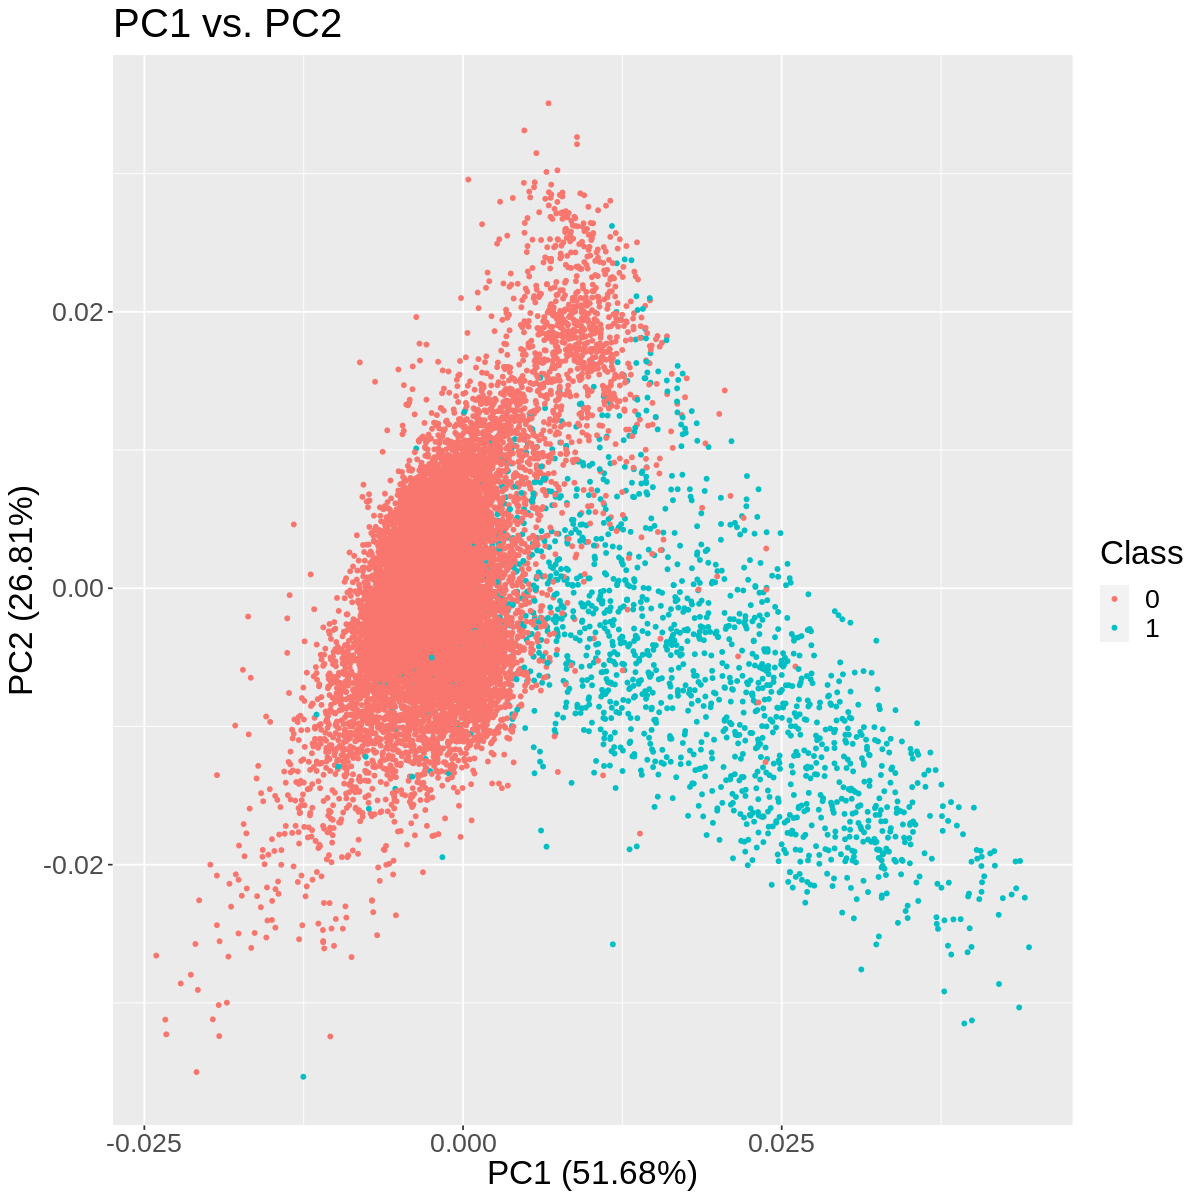

In [39]:
options(repr.plot.width = 10, repr.plot.height = 10) 
autoplot(pulsar_pca, data = pulsar_df, colour = 'Class', size = 1, main = "PC1 vs. PC2") + 
    theme(text = element_text(size=20)) 

Figure 7: PC1 vs. PC2 plot

With the first two principal components, the "PC1 vs. PC2" plot above shows that there is clear separation between the Class 0 and Class 1: especially on PC1, most of observations from Class 1 lies on positive value of PC1 and Class 0 lies on negative value of PC1. This is a clear indication that the data is suitable for some kind of classification model with just the two dimensions obtained from PCA.

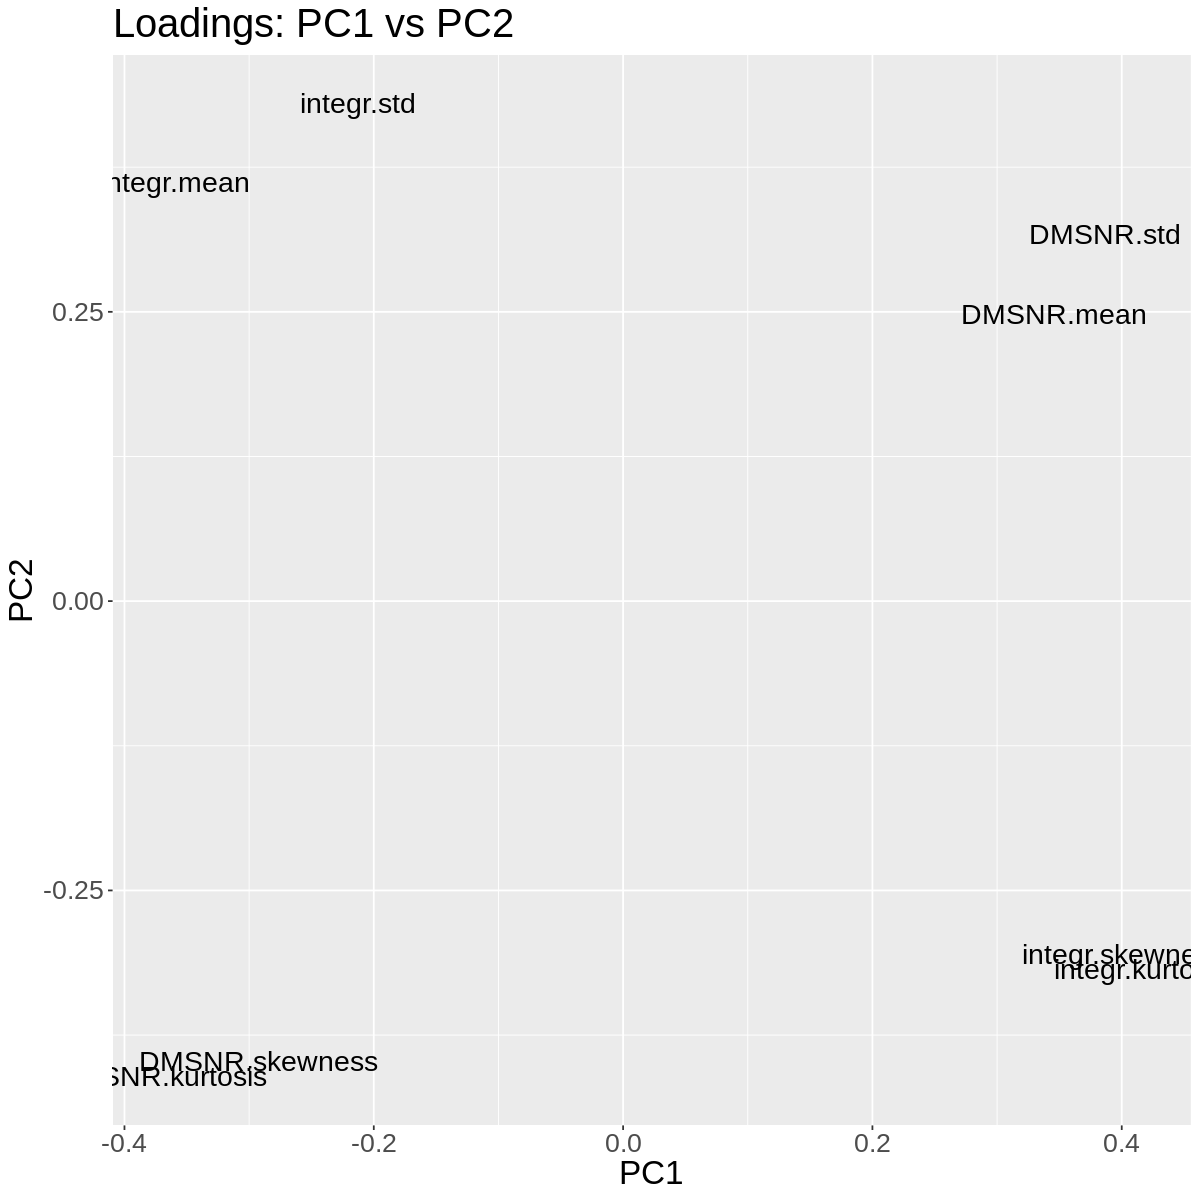

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10) 
data.frame(pulsar_pca$rotation[, 1:2], 
           predictors = rownames(pulsar_pca$rotation)) %>%
  ggplot(aes(PC1, PC2, label = predictors)) + 
  geom_text(cex = 6) + 
  ggtitle("Loadings: PC1 vs PC2") + 
  theme(text = element_text(size=20))

Figure 8: plot for Loadings:PC1 vs. PC2

This plot above shows loadings on each predictors on the first two PCs:

- large values of PC1 are associated with DMSNR.std, DMSNR.mean and integrated.skewness, integrated.kurtosis;

- large values of PC2 are associated with integrated.mean and integrated.std;

- negative values of PC1 and PC2 are associated with DMSNR.skewness and DMSNR.kurtosis;

This plot indicates that all 8 features seem important for the first two principal components. Thus we can easily reduce the dimensions from 8 to 2 by applying PCA.

### 3.2.2 KNN Classification with PCA

Next, we did the similar procedure as before to split the dataset into training (75%) and testing (25%) sets. Moreover, we check the imbalancing problem in our new training set and deal with it use the same method as before to sample down the size of redundant class.

In [42]:
# combine PC1 and PC2 with the original dataset
df <- data.frame(pulsar_pca$x[, 1:2], pulsar_df)

# split the data into training and testing sets
set.seed(123)
df_split <- initial_split(df, prop = 0.75, strata = Class)  
df_train <- training(df_split)   
df_test <- testing(df_split)

In [43]:
# check dimension of training set and count the number of observations in each Class
count_train <- df_train %>% 
  group_by(Class) %>% 
  summarise(n=n()) %>%
  mutate(freq = n / nrow(df_train))
count_train

Class,n,freq
<fct>,<int>,<dbl>
0,12170,0.90665276
1,1253,0.09334724


Table 13: number of observations (PCA training set) in each class

In [44]:
# same imbalancing problem - sample down the 0 class in the df_train 
set.seed(123)
df_train_c1 <- filter(df_train, Class == 1)
df_train <- df_train %>% 
  filter(Class == 0) %>%
  sample_n(nrow(df_train_c1)) %>%
  rbind(df_train_c1)

#### Visualization for the training set with PCA

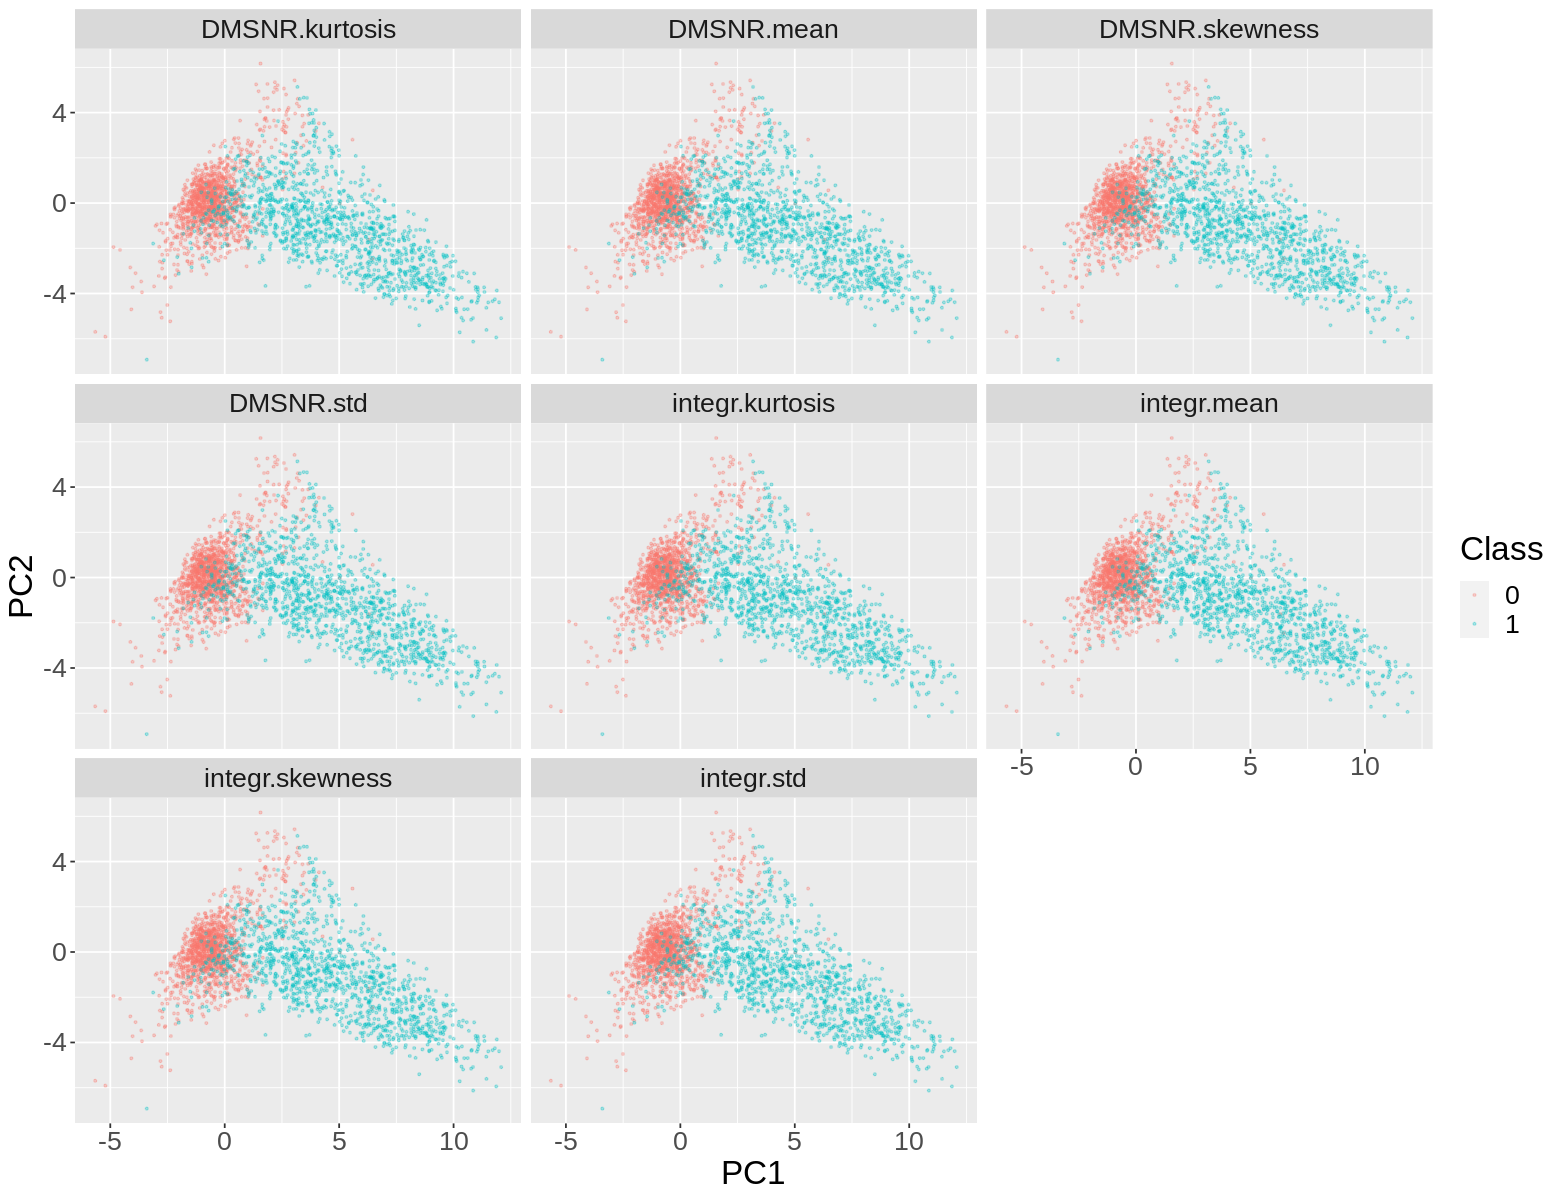

In [45]:
options(repr.plot.width = 13, repr.plot.height = 10) 
df_train %>% 
  pivot_longer(cols = integr.mean:DMSNR.skewness,
               names_to = "predictors") %>%
  ggplot() + 
  geom_point(aes(x = PC1, y = PC2, color = Class), size = 0.5, alpha = 0.3) + 
  facet_wrap(~predictors) + 
  labs(color = "Class") + 
  theme(text = element_text(size=20))

Figure 9: PC1 vs. PC2 for each variable

From the above plot, we see that for each predictors, there's also a clear seperation between the two classes we want to classify, the same pattern shown in the "PC1 vs. PC2" plot for the original dataset.

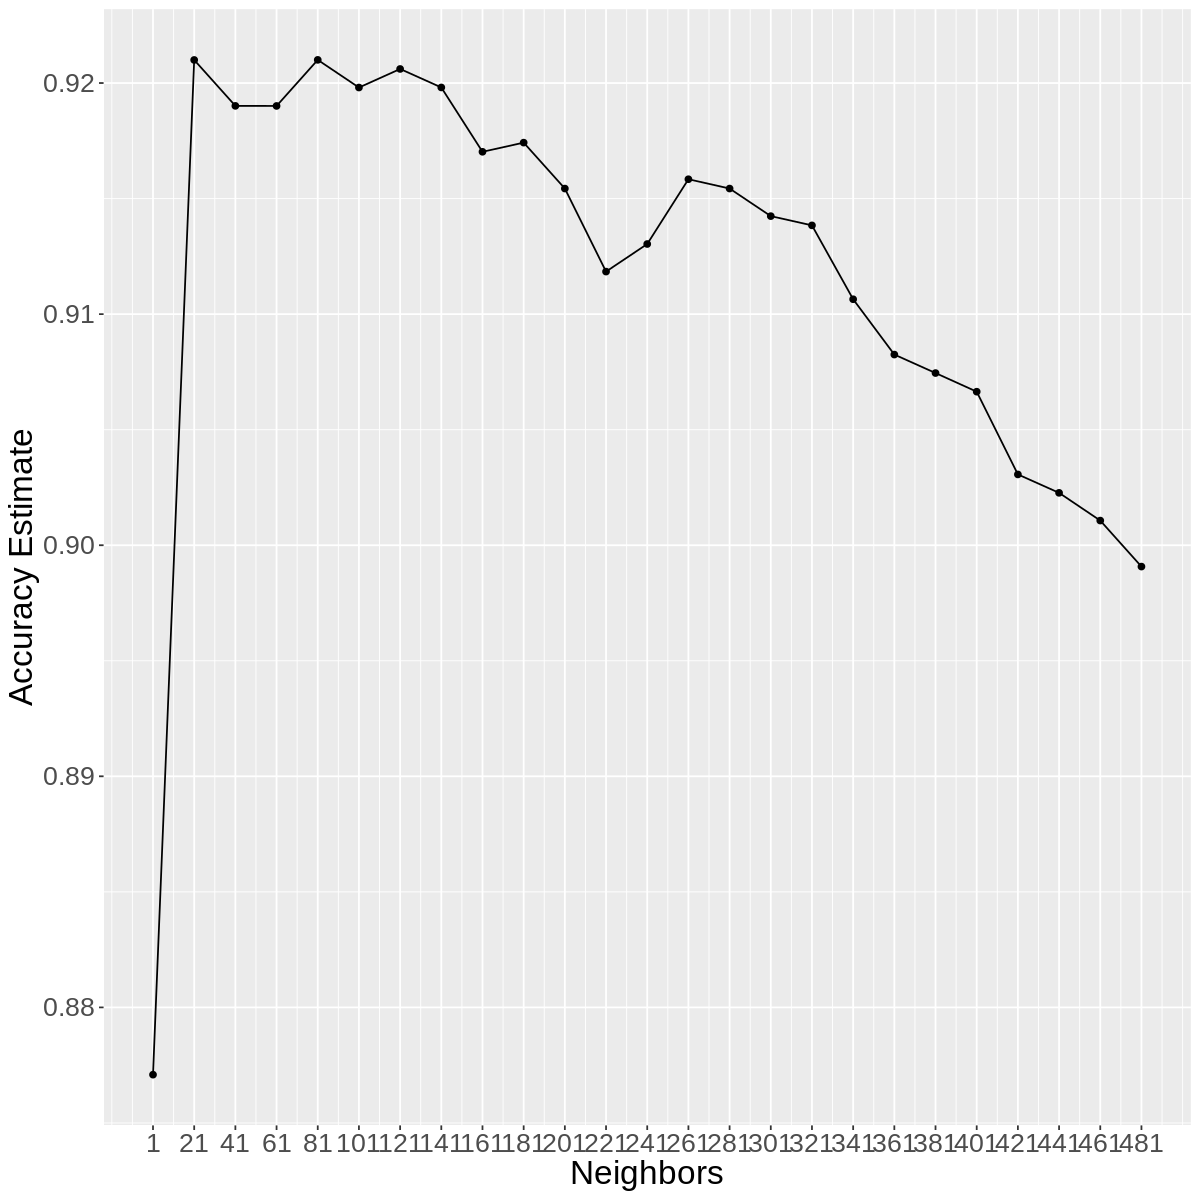

In [46]:
df_train <- select(df_train, PC1, PC2, Class)
set.seed(123)
pca_recipe <- recipe(Class ~ PC1 + PC2 , data = df_train) 
## tuning the parameter
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
# try K with different values:  1 to 500 (stepping by 20)
ks <- tibble(neighbors = seq(from = 1, to = 500, by = 20))
# 10 cross validation
vfold <- vfold_cv(df_train, v = 10, strata = Class)
pca_knn_results <- workflow() %>%
  add_recipe(pca_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 
pca_acc <- pca_knn_results %>%
  filter(.metric == "accuracy")
# accuracy vs k plot
options(repr.plot.width = 10, repr.plot.height = 10) 
ggplot(pca_acc, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", main = "Accuracy VS K") + 
  theme(text = element_text(size = 20)) + 
  scale_x_continuous(breaks = ks$neighbors)

Figure 10: Accuracy vs. K plot (PCA with KNN classification)

In [47]:
pca_acc

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8770889,10,0.004970919,Preprocessor1_Model01
21,accuracy,binary,0.9210000,10,0.005097690,Preprocessor1_Model02
41,accuracy,binary,0.9190127,10,0.005021463,Preprocessor1_Model03
61,accuracy,binary,0.9190095,10,0.005199974,Preprocessor1_Model04
81,accuracy,binary,0.9210032,10,0.004536779,Preprocessor1_Model05
101,accuracy,binary,0.9198063,10,0.004523169,Preprocessor1_Model06
121,accuracy,binary,0.9206095,10,0.004959444,Preprocessor1_Model07
141,accuracy,binary,0.9198095,10,0.004512944,Preprocessor1_Model08
161,accuracy,binary,0.9170254,10,0.004626518,Preprocessor1_Model09


Table 14: accuracies results

In [48]:
# get the best k
pca_acc[which.max(pca_acc$mean), ]
best_pca_k <- pca_acc[which.max(pca_acc$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,accuracy,binary,0.9210032,10,0.004536779,Preprocessor1_Model05


In [49]:
# build the model using the best k choose from examine the accuracies
set.seed(123)
pca_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_pca_k) |>
  set_engine("kknn") %>%
  set_mode("classification")
pca_pulsar_fit <- workflow() %>%
  add_recipe(pca_recipe) %>%
  add_model(pca_spec) %>%
  fit(data = df_train)

# predict the test set
pca_preds <- predict(pca_pulsar_fit, df_test) %>%
  bind_cols(df_test)
# prediction accuracy
pca_preds %>% 
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy") 
# confusion matrix
pca_preds %>%
  conf_mat(truth = Class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9617877


          Truth
Prediction    0    1
         0 3982   64
         1  107  322

Table 15: Confusion Matrix

Then we repeated the same precedures as before with the knn algorithm by first tuning the parameter and found the best k (k = 81) to fit the model and predicted the testing set. The accuracy for testing set is about 96%, which means that 96% of the predicted class is the same as the actual class and only 4% of the time we make mistakes.

________________________________

# 4. Discussion

## 4.1 Conclusions and Potential Limitations for Improvement

From our classification of the dataset, we found that using correlation matrix to choose the predictors could results in a much better and more accurate classification model, comparing with the forward selection method for predictors.
<br>
<br>
The combination of predictors including "integr.mean, integr.kurtosis, DMSNR.std, DMSNR.kurtosis, and integr.skewness", chosen from correlation matrix, could accurately predict whether the detection is a pulsar or not. As this project was an exploratory analysis, we were not entirely sure whether any accurate model would be found. But given the initial analysis we expected that our five chosen predictors would be at least somewhat effective in performing a classification. 
<br>
<br>
However, there's the `Multicollinearity Problem` since the correlation between each predictors are very strong. Also, larger features could result in `curse of dimensionality`, which occurs when large number of features deteriorate the performance of KNN. When we deal with dataset which has large features/dimensions, KNN algorithm choose k-nearest neighbors depends on distance function, regardless of the actual features of the dataset, thus as number of predictors increases, some of the nearest neighbor points may not actually near from the point we want to predict.
<br>
<br>
Therefore, the additional analysis with PCA is more accurate (accuracy = 96%), even though the accuracy score just increased a little, comparing the knn-classification which has 93% of accuracy. PCA could help deal with the Multicollinearity problem and reduce the dimension of the model but keeping as much variance of the data as possible.
<br>
<br>
When we using the PCA method with knn-classification, we got a relatively larger k value (k = 81).  While examing the accuracies metrics above (Table 14), which we got when tunning the parameters with PCA, we found that when k=21, it has almost the same accuracy as k=81 on the training set. Here is the `Bias and Variance Trade-off` problem comes out. If we have multiple K's that have almost the same accuracy scores, choosing the larger K will result in higher bias and lower variance; and choosing the smaller K will result in lower bias and higher variance for the model. We need further analysis in future improvement with the model to think about the Bias and Variance Trade-off.

## 4.2 Impact and Future Questions

The question of whether the 96% accuracy is high enough to use in the real world depends on what this data is being used for. For general interest and scientific exploration, it’s a fairly good number and holds a high certainty. However, if this data were to be used for projects involving human space exploration, for example, or even simply in calculations involving space projects, that 4% uncertainty can pose a big risk to safety. Despite the accuracy being an objectively high percent, there are some instances where even a small amount of risk can be deadly. However, pulsar star data is generally used to test mathematical conditions, and as such, the accuracy is sufficient.

This data analysis could help promote the automation of pulsar classification, which would save astronomers a lot of time and effort. At present, each data point must be manually analyzed, and seeing as there’s upwards of 10,000 entries, this task is very time consuming. Using a model to predict the classification of pulsar stars would allow scientists to spend more time applying this data to further research. 

Our classification can lead to future questions, such as whether we can further classify stars using the same model. For example, differentiating between pulsars, stars, white dwarfs, black holes, and more. With more resources and knowledge of classification, this is a potential question we can one day explore.

________________________________

# WORKS CITED

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate 
Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

R. J. Lyon, HTRU2, DOI: 10.6084/m9.figshare.3080389.v1.

Scaife, A. (n.d.). CSC2019 - Introduction to Machine Learning. CSC2019 - Introduction to machine learning. Retrieved December 4, 2022, from https://as595.github.io/classification/ 